<a href="https://colab.research.google.com/github/davidsjohnson/blockies-xai/blob/shap/SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blockies Dataset

This notebook download the blockies dataset and the corresponding trained model.  This is then used to evaluate the model on all datasets.  

Additionally, we provide a review of the various Blocky traits, to review the distributions between ill and healthy Blockies.

In [ ]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms as T

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import shap
import torchvision


torch.backends.cudnn.benchmark = True

In [ ]:
CLASSES = ['Healthy', 'OCDegen']

modeltype = 'mobilenet'

ds = 'sick_ones_bendbias_v3_2class_normal'
eval_ds = 'sick_ones_bendbias_v3_2class_variation'

random_state = 42

# Setup and Load Datasets

In [ ]:
# data downloading and dataset utilities

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)

    return Path(file_path)

In [ ]:
def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)
  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(self.df.iloc[idx]['ill'])

        if self.transform:
            image = self.transform(image)

        return image, label

## Load Dataset and Dataloaders


In [ ]:
# download data direcly from sciebo
# (or setup own data location if prefered)

data_dir = download_file(url="https://osf.io/download/kexzt/?view_only=adcc520b88cc4ea3b8236c5178ba3ab5",
                         file_name="blockies_datasets.tar.gz",
                         cache_dir='data', # change this if not using Colab
                         extract=True,
                         force_download=False,
                         archive_folder='blockies_datasets')
data_dir

100%|██████████| 1.00G/1.00G [00:42<00:00, 25.5MB/s]


File downloaded to: data/blockies_datasets.tar.gz
File extracted to: data


PosixPath('data/blockies_datasets')

In [ ]:
ds_dir = data_dir / ds
eval_ds_dir = data_dir / eval_ds
ds_dir, eval_ds_dir

(PosixPath('data/blockies_datasets/sick_ones_bendbias_v3_2class_normal'),
 PosixPath('data/blockies_datasets/sick_ones_bendbias_v3_2class_variation'))

In [ ]:
# 2 class dataset
import torch
import torchvision.transforms as T

# Function to convert NCHW (PyTorch) -> NHWC (SHAP)
def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x

# 2 class dataset
mean = np.array([0.8068, 0.7830, 0.8005])
std  = np.array([0.1093, 0.1136, 0.1029])


transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
    T.Lambda(nchw_to_nhwc), # Now defined
    T.Lambda(lambda x: x.cpu().numpy())
    ])

# Load the DataFrames using the load_dataframe function
train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')
eval_df = load_dataframe(eval_ds_dir, 'test')

print(len(train_df), len(val_df), len(test_df), len(eval_df))


train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False,
                              num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                             num_workers=6, pin_memory=True)

eval_dataset = ImageDataset(eval_df,  eval_ds_dir / 'test', transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False,
                             num_workers=6, pin_memory=True)

40000 1000 3000 3000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Model Loading and Evaluation





In [ ]:
def load_mobilenetv2(num_classes, pretrained=True, checkpoint_path=None):
  """Loads a MobileNetV2 model, optionally loading from a checkpoint.

  Args:
    num_classes: The number of output classes.
    pretrained: Whether to load the pre-trained weights.
    checkpoint_path: Path to a checkpoint file to load.

  Returns:
    A MobileNetV2 model.
  """
  model = models.mobilenet_v2(weights=None if not pretrained else 'DEFAULT')
  model.classifier[1] = nn.Linear(model.last_channel, num_classes)

  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    if isinstance(checkpoint, dict) and "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"], strict=False)
    else:
            model.load_state_dict(checkpoint, strict=False)
    print(f"Loaded checkpoint from: {checkpoint_path}")

  return model

In [ ]:
def set_seed(seed):
  """
  Sets random seeds for reproducibility.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    preds = []
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            preds.extend(predicted.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy, np.array(preds)

In [ ]:
checkpoint_path = download_file(url='https://osf.io/download/5crqh/?view_only=adcc520b88cc4ea3b8236c5178ba3ab5',
                                file_name='best_model.pth',
                                cache_dir='checkpoint/mobilenetv2_checkpoint', # change this if not using Colab
                                extract=False,
                                force_download=True)
checkpoint_path

100%|██████████| 8.73M/8.73M [00:01<00:00, 6.72MB/s]

File downloaded to: checkpoint/mobilenetv2_checkpoint/best_model.pth


PosixPath('checkpoint/mobilenetv2_checkpoint/best_model.pth')

In [ ]:
# Load the checkpoint
model1 = torch.load("checkpoint/mobilenetv2_checkpoint/best_model.pth", map_location="cpu")

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# — Helper functions for SHAP pipeline —
from PIL import Image
import numpy as np

# Match your training normalization
mean = np.array([0.8068, 0.7830, 0.8005])
std  = np.array([0.1093, 0.1136, 0.1029])

def load_image(fp: str) -> np.ndarray:
    img = Image.open(fp).convert("RGB")
    return np.array(img) / 255.0

def preprocess(img: np.ndarray) -> np.ndarray:
    return (img - mean[None,None,:]) / std[None,None,:]


## Evaluate Model

In [ ]:
# — Cell A: instantiate model + wrap predict for SHAP —
model = load_mobilenetv2(
    num_classes=len(CLASSES),
    pretrained=False,
    checkpoint_path=checkpoint_path
)
model.to(device).eval()

def predict_fn(x: np.ndarray) -> np.ndarray:
    t = torch.from_numpy(x).permute(0,3,1,2).float().to(device)
    with torch.no_grad():
        out   = model(t)
        probs = torch.nn.functional.softmax(out, dim=1)
    return probs.cpu().numpy()


Loaded checkpoint from: checkpoint/mobilenetv2_checkpoint/best_model.pth


In [48]:
# Sample a Few Blockie Images
sample_df = eval_df.sample(n=10, random_state=42).reset_index(drop=True)
raw_imgs  = [load_image(str(eval_ds_dir/'test'/fn)) for fn in sample_df['filename']]
norm_imgs = [preprocess(img) for img in raw_imgs]

In [49]:
# Setup SHAP for Explaining Predictions
masker = shap.maskers.Image("blur(4,4)", raw_imgs[0].shape)
def predict_nhwc(x):
    t = torch.from_numpy(np.stack(x)).permute(0,3,1,2).float().to(device)
    with torch.no_grad():
        p = torch.nn.functional.softmax(model(t), 1).cpu().numpy()
    return p
explainer = shap.Explainer(predict_nhwc, masker, algorithm="partition")

In [50]:
# Setup Output Folders
out = Path("outputs_test")
img_dir = out / "images"
shap_dir = out / "shap"

img_dir.mkdir(parents=True, exist_ok=True)
shap_dir.mkdir(parents=True, exist_ok=True)


  0%|          | 0/498 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [01:04, 64.97s/it]               


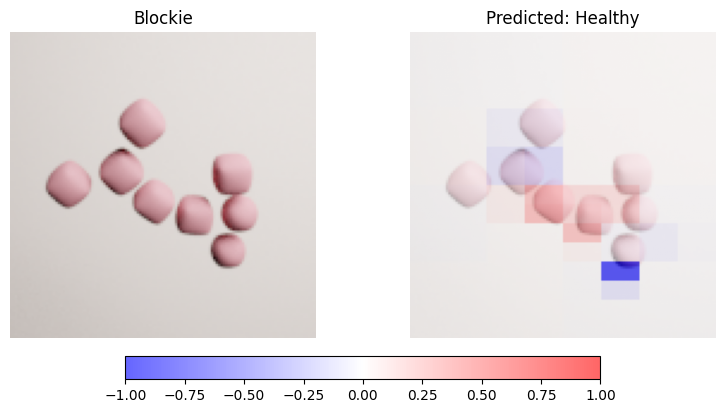

  0%|          | 0/498 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [01:00, 60.94s/it]               


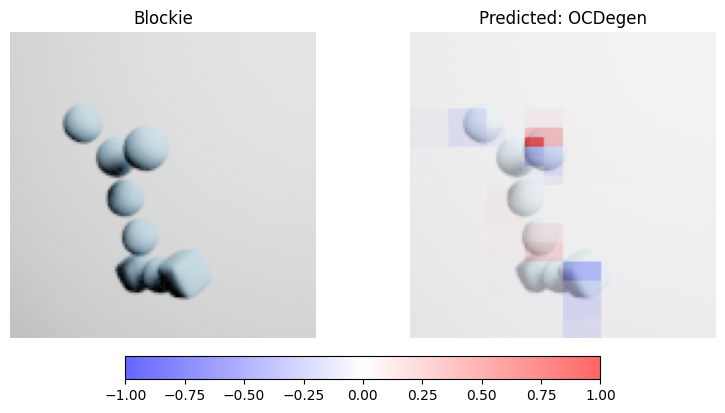

  0%|          | 0/498 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [01:00, 60.73s/it]               


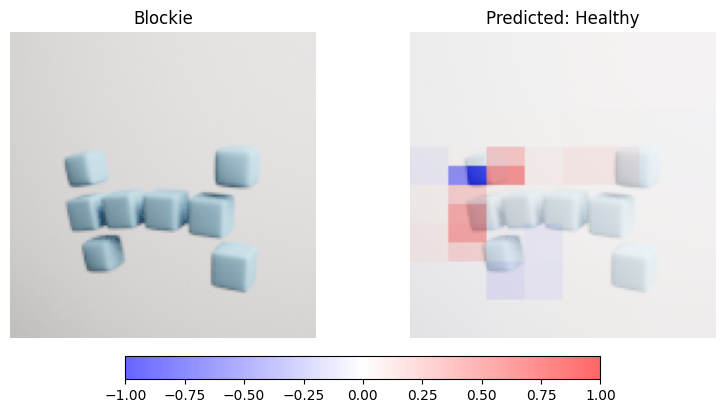

  0%|          | 0/498 [00:00<?, ?it/s]



PartitionExplainer explainer: 2it [01:00, 60.55s/it]               


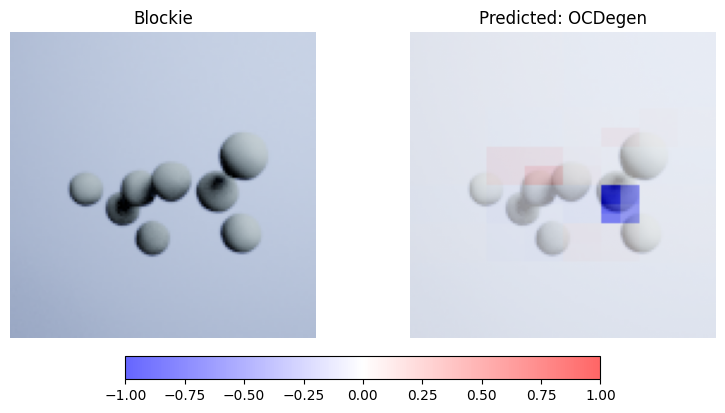

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:00, 60.38s/it]               


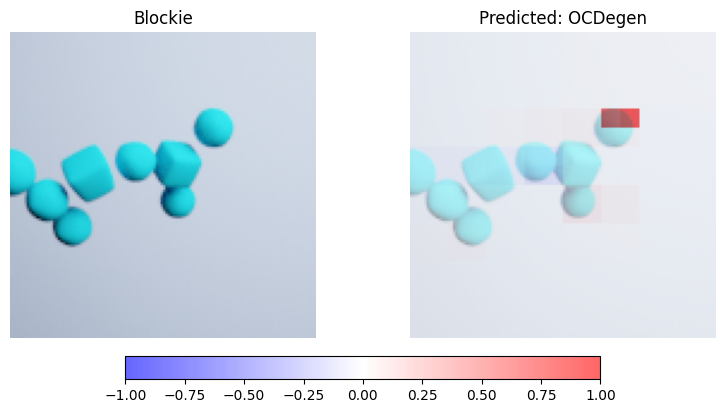

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:00, 60.73s/it]               


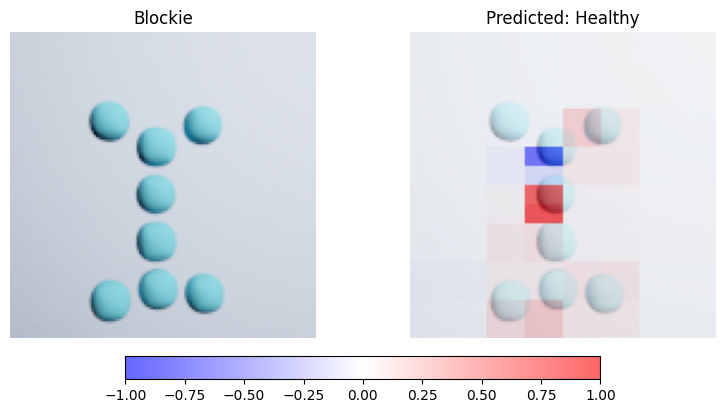

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:00, 60.88s/it]               


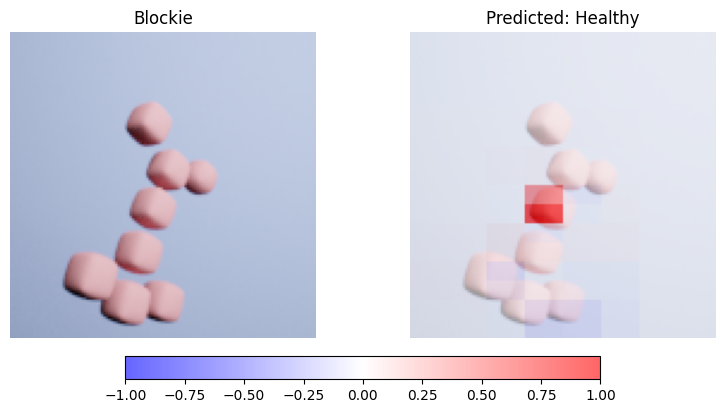

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:01, 61.07s/it]               


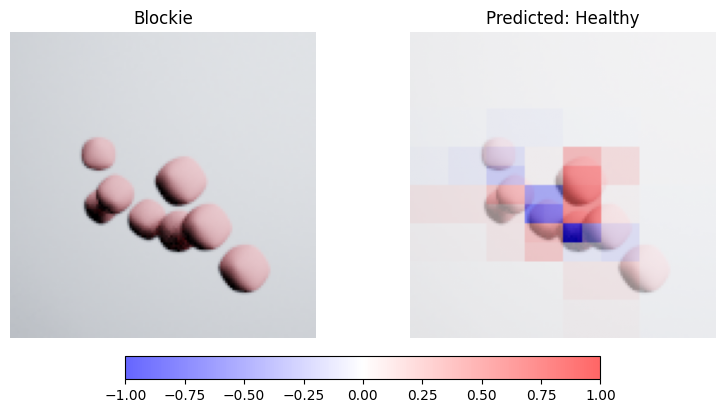

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:00, 60.91s/it]               


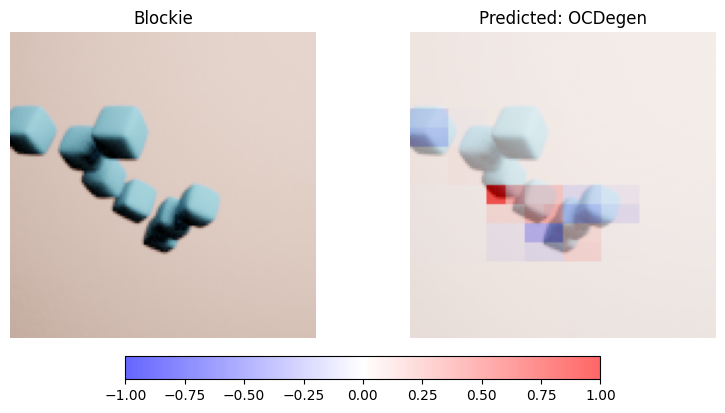

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:00, 60.99s/it]               


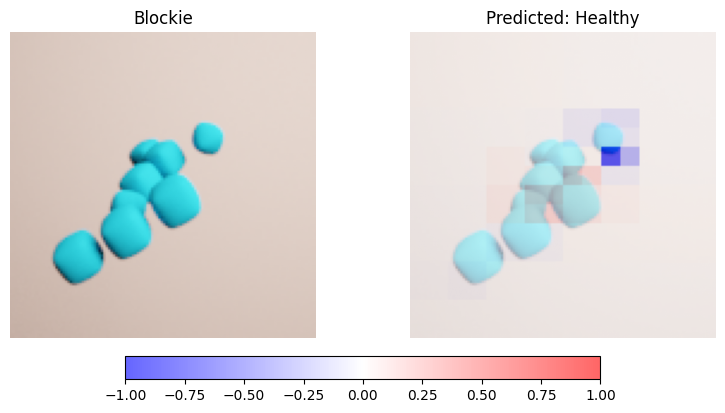

In [51]:
# Output Loop
for idx, (raw, norm) in enumerate(zip(raw_imgs, norm_imgs)):
    # 1) Save raw image
    plt.imsave(img_dir / f"blockie_{idx}.png", raw)

    # 2) Predict class
    probs     = predict_nhwc([norm])[0]
    pred_cls  = int(np.argmax(probs))
    pred_name = CLASSES[pred_cls]

    # 3) Get SHAP values
    exp = explainer(norm[np.newaxis, ...])

    # 4) Select predicted class correctly from 5D SHAP output
    if exp.values.ndim == 5:
        values = exp.values[0, ..., pred_cls]  # shape (H, W, C)
    elif exp.values.ndim == 4:
        values = exp.values[pred_cls]          # fallback
    elif exp.values.ndim == 3:
        values = exp.values                    # already fine
    else:
        print(f"Skipping idx={idx}: unknown SHAP shape {exp.values.shape}")
        continue

    # 5) Collapse to 2D: signed importance
    heatmap = values.sum(axis=-1)  # shape (H, W)

    # 6) Normalize to [-1, 1] range
    vmax = np.max(np.abs(heatmap)) + 1e-12
    heatmap_norm = heatmap / vmax

    # 7) Plot raw + heatmap
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

    # Left: Raw blockie
    axes[0].imshow(raw)
    axes[0].set_title("Blockie")
    axes[0].axis("off")

    # Right: SHAP overlay
    axes[1].imshow(raw)
    hm = axes[1].imshow( heatmap_norm, cmap='bwr', alpha=0.6, vmin=-1, vmax=1)
    axes[1].set_title(f"Predicted: {pred_name}")
    axes[1].axis("off")

    # Colorbar across both
    fig.colorbar(hm, ax=axes.ravel().tolist(), shrink=0.6,
                orientation="horizontal", pad=0.05)
    plt.savefig(shap_dir / f"shap_{idx}.png", bbox_inches='tight')
    plt.show()
    plt.close(fig)


In [47]:
# CSV file creation
import pandas as pd

output_csv_path = out / "input.csv"
rows = []

for idx, (row, norm) in enumerate(zip(sample_df.itertuples(index=False), norm_imgs)):
    # Predict class
    probs      = predict_nhwc([norm])[0]
    pred_cls   = int(np.argmax(probs))
    pred_label = CLASSES[pred_cls]

    # Use "ill" column and convert safely to int
    ill_val = getattr(row, "ill", None)
    true_label = CLASSES[int(ill_val)] if ill_val is not None else "UNKNOWN"

    # Final row
    rows.append({
        "INDEX": idx,
        "PATIENT_ID": f"PT{1000 + idx}",
        "IMAGE_FILE": f"blockie_{idx}.png",
        "TRUE_LABEL": true_label,
        "SUGGESTED_LABEL": pred_label,
        "EXPLANATION": f"shap_{idx}.png"
    })

# Save the CSV
df_out = pd.DataFrame(rows)
df_out.to_csv(output_csv_path, index=False)
print(f"input.csv created: {output_csv_path}")



input.csv created: outputs_test/input.csv


In [ ]:
print(sample_df.columns)
print(sample_df[['label']].head())

Index(['obj_name', 'labeling_error', 'spherical', 'ill', 'ill_chars',
       'ill_spherical', 'num_diff', 'bending', 'obj_rotation_roll',
       'obj_rotation_pitch', 'obj_rotation_yaw', 'fliplr', 'position_x',
       'position_y', 'arm_position', 'obj_color', 'obj_color_rgba', 'bg_color',
       'bg_color_rgba', 'resolution', 'id', 'original_id',
       '_attributes_status', 'label', '__module__', '__name__', 'filename'],
      dtype='object')
   label
0  peaky
1  peaky
2  peaky


In [ ]:
print(sample_df[['label', 'ill', 'filename']].head())

   label ill                                  filename
0  peaky   0  2764feb5-930d-4ea4-92e4-d53a6b0d7d71.png
1  peaky   1  32ea1029-b81b-4529-81f7-bad17f8faa79.png
2  peaky   0  f9445792-677c-420f-bf59-e793689abdc5.png


In [ ]:
#for idx, (raw, norm) in enumerate(zip(raw_imgs, norm_imgs)):
    # save raw blockie
    #plt.imsave(out/"images"/f"blockie_{idx}.png", raw)

    # explain -> exp.values shape (1, H, W, C)
    #exp = explainer(norm[np.newaxis, ...])

    # shap.image_plot wants *lists*  [array], [image]
    #shap.image_plot(exp, pixel_values=np.expand_dims(raw, 0), show=False)
    #plt.savefig(shap_dir/f"shap_{idx}.png", bbox_inches="tight")
    #plt.clf()